# Векторизованное тестирование на актуальных исторических данных

Прежде чем запускать данный алгоритм необходимо сначала актуализировать исторические данные. Для этого запускаем QUIK. Затем в QUIK запускаем алгоритм в основе которого лежит функция CreateDataSource, извлекающая данные из графиков движения цены.

В QUIK должны быть запущены стакан с котировками по нужному инструменту, таблица обезличенных сделок и график. А также скрипт QuikLuaPython

# Получение и обработка данных

In [1]:
# Загружаем необходимые библиотеки и классы (treeinterpreter можно
# установить с помощью команды pip install treeinterpreter)
import time
import pickle
import datetime as dt
from pylab import mpl, plt # импорт библиотеки Matplotlib
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

In [2]:
plt.style.use('seaborn-v0_8-darkgrid') # настройка стиля диаграмм
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [3]:
# загрузка данных из CSV-файла
# Столбцы для использования в качестве меток строки файла DataFrame либо даны как string name или индекс столбца.
# Если задана последовательность INT / STR, используется многоиндекс.
# Примечание: index_col = false может использоваться для форсирования Pands не использовать первый столбец как индекс,
# например, когда у вас есть неправильный файл с разделителями в конце каждой строки.
# Функция читает файл, в котором данные о последней свече находятся в первой строке 
raw = pd.read_csv('BRJ2\Data\BRJ2_Data.csv', index_col=0, parse_dates=False)

In [4]:
raw.info() # информация о файле

<class 'pandas.core.frame.DataFrame'>
Index: 3504 entries, 2022-3-30 to 2022-2-15
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    3504 non-null   object 
 1   Open    3504 non-null   float64
 2   High    3504 non-null   float64
 3   Low     3504 non-null   float64
 4   Close   3504 non-null   float64
 5   Volume  3504 non-null   float64
dtypes: float64(5), object(1)
memory usage: 191.6+ KB


In [5]:
reverse_raw = raw[::-1]

In [6]:
reverse_raw.head()

,Time,Open,High,Low,Close,Volume
Date,,,,,,
2022-2-15,17:45,90.80,90.81,90.56,90.60,268.0
2022-2-15,17:50,90.59,90.70,90.54,90.61,261.0
2022-2-15,17:55,90.58,90.64,90.13,90.55,2932.0
2022-2-15,18:0,90.55,90.58,90.39,90.48,230.0
2022-2-15,18:5,90.44,90.44,90.22,90.31,334.0


In [7]:
symbol = 'Close' # т.к. нам нужны цены закрытия пятиминутных свечей берём данные из колонки Close

In [8]:
m5_close = reverse_raw[symbol] # сохраняем серию в переменную с наиболее подходящим и информативным названием

In [9]:
# формирование подмножества данных и исключение нечисловых значений (NaN))
data = (pd.DataFrame(m5_close).dropna())

In [10]:
# расчёт логарифмической доходности
data['Доходность'] = np.log(data/data.shift(1))

In [11]:
# всегда применяем после shift, т.к. после shift появляются нечисловые значения NaN
data.dropna(inplace=True)

In [12]:
data['Доходность'].head()

Date
2022-2-15    0.000110
2022-2-15   -0.000662
2022-2-15   -0.000773
2022-2-15   -0.001881
2022-2-15   -0.000443
Name: Доходность, dtype: float64

In [13]:
# Функция sign() является указателем на знак числа. Если число со знаком минус, то возвращает -1, если с плюсом, то 1
# Функция astype() преобразует в указанный тип данных, в данном случае int
data['Направление'] = np.sign(data['Доходность']).astype(int)

In [14]:
lags = 5 # поменяли количество 2 на 5

In [15]:
# это не относится к данному разделу, просто проверка работоспособности кода
features = data['Направление'].iloc[-(lags + 1):-1] 

In [16]:
# смотрим, что за тип данных
type(features)

pandas.core.series.Series

In [17]:
# наглядно
features.head()

Date
2022-3-30   -1
2022-3-30    1
2022-3-30   -1
2022-3-30    1
2022-3-30   -1
Name: Направление, dtype: int32

In [18]:
features

Date
2022-3-30   -1
2022-3-30    1
2022-3-30   -1
2022-3-30    1
2022-3-30   -1
Name: Направление, dtype: int32

In [19]:
features = features.values.reshape(1, -1)

In [20]:
type(features)

numpy.ndarray

In [21]:
features

array([[-1,  1, -1,  1, -1]])

Продолжение раздела, чтобы не перепутать, что откуда берётся

In [22]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['Доходность'].shift(lag) # обратить внимание на каком этапе появляются data[col]
        cols.append(col)

In [23]:
create_lags(data)

In [24]:
data.dropna(inplace=True)

In [25]:
type(data)

pandas.core.frame.DataFrame

In [26]:
data.head()

,Close,Доходность,Направление,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2022-2-15,90.38,0.001218,1,-0.000443,-0.001881,-0.000773,-0.000662,0.000110
2022-2-15,90.68,0.003314,1,0.001218,-0.000443,-0.001881,-0.000773,-0.000662
2022-2-15,90.80,0.001322,1,0.003314,0.001218,-0.000443,-0.001881,-0.000773
2022-2-15,90.70,-0.001102,-1,0.001322,0.003314,0.001218,-0.000443,-0.001881
2022-2-15,90.58,-0.001324,-1,-0.001102,0.001322,0.003314,0.001218,-0.000443


In [27]:
# дискретизация значений признаков с учётом параметра bins
def create_bins(data, bins=[0]):
    global cols_bin # объявляем глобальную переменную
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin' # преобразуем названия колонок
        # Функция digitize Возвращает индексы бинов,к которым принадлежит каждое значение во входном массиве.
        # Если значения в x выходят за пределы bins , соответственно возвращается 0 или len(bins). Т.е. отрицательные значения преобразуем в 0, а положительные в 1
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append (col_bin )

In [28]:
create_bins(data)
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [29]:
type(data)

pandas.core.frame.DataFrame

In [30]:
data.head()

,Close,Доходность,Направление,lag_1,lag_2,lag_3,lag_4,lag_5,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,,,,,,,,,
2022-2-15,90.38,0.001218,1,-0.000443,-0.001881,-0.000773,-0.000662,0.000110,0,0,0,0,1
2022-2-15,90.68,0.003314,1,0.001218,-0.000443,-0.001881,-0.000773,-0.000662,1,0,0,0,0
2022-2-15,90.80,0.001322,1,0.003314,0.001218,-0.000443,-0.001881,-0.000773,1,1,0,0,0
2022-2-15,90.70,-0.001102,-1,0.001322,0.003314,0.001218,-0.000443,-0.001881,1,1,1,0,0
2022-2-15,90.58,-0.001324,-1,-0.001102,0.001322,0.003314,0.001218,-0.000443,0,1,1,1,0


In [31]:
# Отображение дискретных значений признаков и меток
data[cols_bin + ['Направление']].head(10)

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin,Направление
Date,,,,,,
2022-2-15,0,0,0,0,1,1
2022-2-15,1,0,0,0,0,1
2022-2-15,1,1,0,0,0,1
2022-2-15,1,1,1,0,0,-1
2022-2-15,0,1,1,1,0,-1
2022-2-15,0,0,1,1,1,-1
2022-2-15,0,0,0,1,1,1
2022-2-15,1,0,0,0,1,-1
2022-2-15,0,1,0,0,0,1


In [32]:
grouped = data.groupby(cols_bin + ['Направление'])
grouped.size() # Отображение частоты возможных движений в зависимости от комбинаций значений признаков

lag_1_bin  lag_2_bin  lag_3_bin  lag_4_bin  lag_5_bin  Направление
0          0          0          0          0          -1             26
                                                        1             35
                                            1          -1             35
                                                        0              3
                                                        1             40
                                                                      ..
1          1          1          1          0           0              5
                                                        1             42
                                            1          -1             47
                                                        0             54
                                                        1             39
Length: 95, dtype: int64

In [33]:
# Преобразование объекта DataFrame, чтобы частоты хранились по столбцам.
res = grouped['Направление'].size().unstack(fill_value=0)

In [34]:
# Определение наиболее часто встречающегося значения для каждой комбинации значений признаков.
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [35]:
# Определение наиболее часто встречающегося значения для каждой комбинации значений признаков.
res.style.apply(highlight_max, axis=1)

In [36]:
# Преобразование полученного частотного распределения в торговую стратегию
# Функция where() возвращает элементы, которые могут выбираться из двух массивов в зависимости от условия
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)

In [37]:
type(data['pos_freq'])

pandas.core.series.Series

In [38]:
data['pos_freq'].head()

Date
2022-2-15    1
2022-2-15    1
2022-2-15   -1
2022-2-15    1
2022-2-15    1
Name: pos_freq, dtype: int32

In [39]:
(data['Направление'] == data['pos_freq']).value_counts()

False    1826
True     1672
Name: count, dtype: int64

In [40]:
data['strat_freq'] = data['pos_freq'] * data['Доходность']

# Обработка данных с помощью алгоритма RandomForest

In [41]:
model = RandomForestClassifier(n_estimators=150)

In [42]:
split = int(len(data ) * 0.80) 

In [43]:
train = data.iloc[:split].copy() 

In [44]:
model.fit(data[cols_bin], data['Направление'])

RandomForestClassifier(n_estimators=150)

In [45]:
accuracy_score(train['Направление'], model.predict(train[cols_bin]))

0.5285918513223731

In [46]:
test = data.iloc[split:].copy() 

In [47]:
test['position'] = model.predict(test[cols_bin]) 

In [48]:
accuracy_score(test['Направление'], test['position'])

0.5157142857142857

In [49]:
test['strategy'] = test['position'] * test['Доходность']

In [50]:
sum(test['position'].diff() != 0)

334

In [51]:
test[['Доходность', 'strategy']].sum().apply(np.exp) 

Доходность    1.000887
strategy      1.121944
dtype: float64

<Axes: xlabel='Date'>

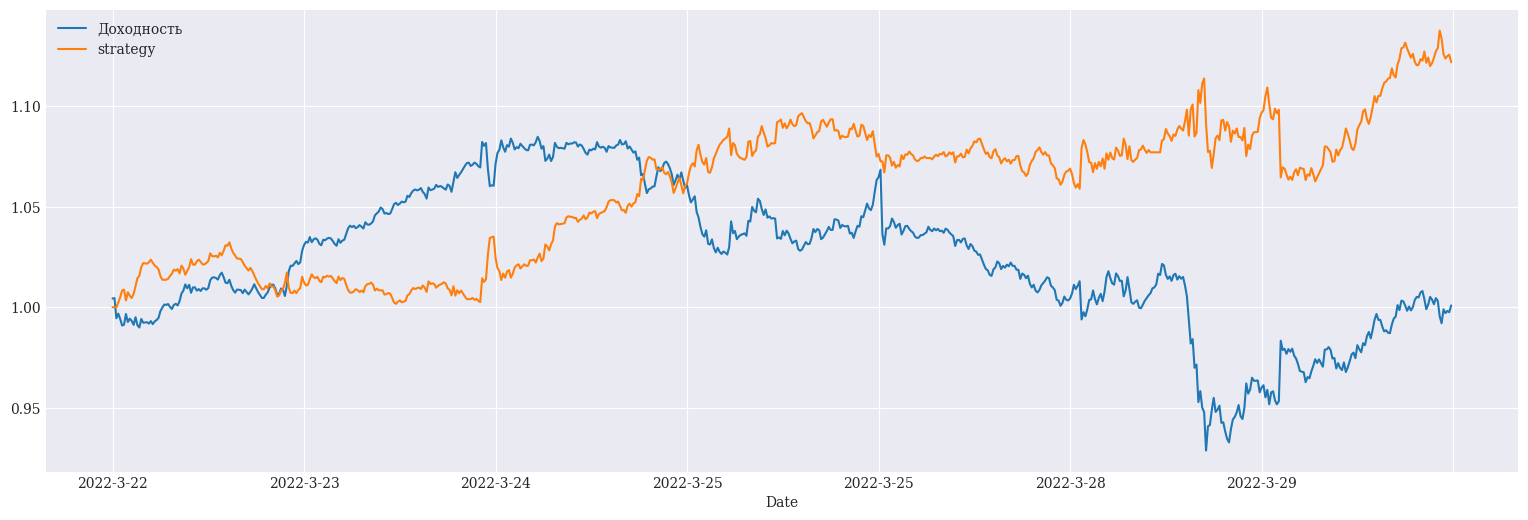

In [52]:
test[['Доходность', 'strategy']].cumsum().apply(np.exp).plot(figsize=(19, 6))

In [53]:
pickle.dump(model, open('algorithm.pkl', 'wb')) # сохраняем модель в файл, который будет храниться в той же папке

# Сохранение объекта модели

In [54]:
algorithm = pickle.load(open('algorithm.pkl', 'rb')) # загружаем модель из сохранённого файла

In [55]:
cignal = algorithm.predict(features)[0] # первый вариант получения сигнала

e:\repo\TradingAlgorithmsandAutomations\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [56]:
signal = model.predict(features)[0] # второй вариант

e:\repo\TradingAlgorithmsandAutomations\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [57]:
signal

-1

In [58]:
type(signal)

numpy.int32

# Запуск алгоритма в режиме реального времени с периодическим обновлением данных

До этого момента мы тестировали алгоритм торговой стратегии в автономном режиме. Другими словами, для решения поставленной задачи ему требовался полный набор данных. Основная трудность заключалась в обучении SVM-алгоритма на бинарных признаках и метках, задающих направление движения. На практике при развертывании системы алгоритмической торговли для работы на финансовых рынках данные будут обрабатываться по мере поступления, и предсказываться будет направление рыночного движения в следующем временном интервале. В этом разделе мы интегрируем сохраненный объект модели в среду потоковой обработки данных.
Программа, которая преобразует автономный алгоритм в систему реального времени, должна решить следующие основные задачи.
Обработка данных свечей:
Данные свечей поступают в реальном времени и должны обрабатываться в потоковом режиме.
Повторная выборка данных:
Данные свечей нужно перевыбирать в соответствии с величиной интервала, установленного в алгоритме торговой стратегии.
Прогнозирование:
Торговый алгоритм прогнозирует направление рыночного движения в будущие периоды.
Размещение заявок:
С учетом текущей позиции и сгенерированного прогноза (“сигнала”) программа должна либо размещать заявку, либо удерживать позицию.

Мы получаем данные свечей из периодически обновляемого файла CSV. Затем обрабатываем алгоритмом и генерируем сигнал

In [59]:
struct = time.localtime()
type(struct.tm_sec)

int

In [60]:
struct.tm_sec

21

In [61]:
# разобраться с ебучим циклом он сука не работает. Признаком его работы должно быть появление файла signal
# заебись, вроде работает
while True:
    struct = time.localtime()
    if struct.tm_sec == 40:
        # загрузка данных из CSV-файла
        # Столбцы для использования в качестве меток строки файла DataFrame либо даны как string name или индекс столбца.
        # Если задана последовательность INT / STR, используется многоиндекс.
        # Примечание: index_col = false может использоваться для форсирования Pands не использовать первый столбец как индекс,
        # например, когда у вас есть неправильный файл с разделителями в конце каждой строки.
        # Функция читает файл, в котором данные о последней свече находятся в первой строке 
        raw = pd.read_csv('BRJ2\Data\BRJ2_Data.csv', index_col=0, parse_dates=False)
        reverse_raw = raw[::-1] # реверс набора данных
        symbol = 'Close' # т.к. нам нужны цены закрытия пятиминутных свечей берём данные из колонки Close
        m5_close = reverse_raw[symbol] # сохраняем серию в переменную с наиболее подходящим и информативным названием
        # формирование подмножества данных и исключение нечисловых значений (NaN))
        data = (pd.DataFrame(m5_close).dropna())
        # расчёт логарифмической доходности
        data['Доходность'] = np.log(data/data.shift(1))
        # всегда применяем после shift, т.к. после shift появляются нечисловые значения NaN
        data.dropna(inplace=True)
        # Функция sign() является указателем на знак числа. Если число со знаком минус, то возвращает -1, если с плюсом, то 1
        # Функция astype() преобразует в указанный тип данных, в данном случае int
        data['Направление'] = np.sign(data['Доходность']).astype(int)
        features = data['Направление'].iloc[-(lags + 1):-1]
        features = features.values.reshape(1, -1)
        signal = model.predict(features)[0]
        f = open('BRJ2\Signal_and_transaction\signal.txt', 'w') # вместо а+ лучше поставить w или w+, т.к. дозапись необязательна
        f.write(str(signal)) # секунды убрать нахуй, мешать будут и перевод строки
        f.close()
        continue
    else:
        continue
        

KeyboardInterrupt: 